In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')

import time
from glob import glob
from tqdm import tqdm

import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras import backend as K
# from keras.utils import plot_model

from keras.layers import Activation, Dense, LSTM, GRU, Bidirectional, AveragePooling1D, GlobalAveragePooling1D, Dropout, Flatten, BatchNormalization, TimeDistributed, Input, Reshape, RepeatVector, Concatenate, GlobalMaxPooling1D 
from keras.layers.convolutional import Conv1D, MaxPooling1D, AveragePooling1D


#GPU 자원이 부족
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
raw_data = pd.read_csv('/content/drive/MyDrive/신입기수 프로젝트/Dataset/rawdata.csv')

In [4]:
raw_data

,날짜,현재수위,유입량,저수량,공용량,방류량,강화대교_조위,청담대교_유량,잠수교_유량,한강대교_유량,행주대교_유량,대곡교_강수량,진관교_강수량,송정동_강수량,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위
0,2012-05-01 00:00,24.800,555.00,219.07,24.93,555.00,445.0,469.05,0.0,729.80,540.18,0.0,0.0,0.0,310.7,300.2,290.0,275.3
1,2012-05-01 00:10,24.794,464.60,218.86,25.15,562.90,449.0,498.00,0.0,731.48,540.18,0.0,0.0,0.0,314.7,300.2,290.0,275.3
2,2012-05-01 00:20,24.789,478.10,218.69,25.31,576.40,451.0,490.68,0.0,726.42,540.18,0.0,0.0,0.0,313.7,301.2,290.0,275.3
3,2012-05-01 00:30,24.789,464.80,218.69,25.31,563.10,452.0,476.21,0.0,726.42,552.17,0.0,0.0,0.0,311.7,301.2,290.0,276.3
4,2012-05-01 00:40,24.789,478.10,218.69,25.31,576.40,450.0,476.21,0.0,707.17,564.29,0.0,0.0,0.0,311.7,301.2,291.0,277.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276331,2022-07-18 23:10,25.040,259.23,212.86,31.14,259.23,510.0,319.84,NaN,-456.41,974.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0
276332,2022-07-18 23:20,25.040,260.46,212.86,31.14,260.46,492.0,314.01,NaN,-717.30,1006.88,0.0,0.0,0.0,0.0,0.0,0.0,0.0
276333,2022-07-18 23:30,25.040,259.37,212.86,31.14,259.37,475.0,387.55,NaN,-843.37,1039.90,0.0,0.0,0.0,0.0,0.0,0.0,0.0
276334,2022-07-18 23:40,25.040,259.13,212.86,31.14,259.13,458.0,454.91,NaN,-1023.37,1073.46,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
raw_data = raw_data['행주대교_수위']

In [6]:
nanIndex = raw_data[raw_data.isnull()==True].index

In [7]:
nanIndex

Int64Index([140613, 140614, 140615, 140616, 140617, 140618, 140619, 140620,
            140621, 140622, 140623, 140624, 140625, 140626, 140627, 140628,
            140629, 140630, 140631, 140632, 140633, 140634, 140635, 140636,
            140637, 140638, 140639, 140640, 140641, 140642, 140643, 140644,
            140645, 140646, 140647, 140648, 140649, 140650, 140651, 140652,
            140653, 140654, 140655, 140656, 140657, 140658, 140659, 140660,
            140661, 140662, 140663, 140664, 140665, 140666, 140667, 140668,
            140669, 140670, 236080],
           dtype='int64')

In [8]:
consecutive = list(nanIndex)[:-1]
unconsecutive = list(nanIndex)[-1]
print(consecutive)
print(unconsecutive)

[140613, 140614, 140615, 140616, 140617, 140618, 140619, 140620, 140621, 140622, 140623, 140624, 140625, 140626, 140627, 140628, 140629, 140630, 140631, 140632, 140633, 140634, 140635, 140636, 140637, 140638, 140639, 140640, 140641, 140642, 140643, 140644, 140645, 140646, 140647, 140648, 140649, 140650, 140651, 140652, 140653, 140654, 140655, 140656, 140657, 140658, 140659, 140660, 140661, 140662, 140663, 140664, 140665, 140666, 140667, 140668, 140669, 140670]
236080


In [9]:
print(len(consecutive) + 1 == len(nanIndex) )

True


In [10]:
# 58개 결측치 앞 인덱스까지 인풋 생성
x = raw_data.iloc[:140613]

In [11]:
x

0         275.3
1         275.3
2         275.3
3         276.3
4         277.3
          ...  
140608    374.3
140609    375.3
140610    373.3
140611    373.3
140612    375.3
Name: 행주대교_수위, Length: 140613, dtype: float64

In [12]:
y_predict = []

xtrain = []
ytrain = []

w =  500 # window size
n = 58 # 예측할 데이터 개수

for i in tqdm(range(len(x)-w-n)):
    xtrain.append(np.array(x.iloc[i:i + w]).astype(float))
for i in tqdm(range(w, len(x)-n)):
  ytrain.append(np.array(x.iloc[i:i+n]).astype(float))

100%|██████████| 140055/140055 [00:05<00:00, 25204.81it/s]


In [20]:
xtrain = np.array(xtrain).reshape(140055, 500, 1)
ytrain = np.array(ytrain).reshape(140055, 58,)

In [14]:
def inverse_transform(y_test, yhat):
     y_test_reshaped = y_test.reshape(-1, y_test.shape[-1])
     yhat_reshaped = yhat.reshape(-1, yhat.shape[-1])
     yhat_inverse = scaler.inverse_transform(yhat_reshaped)
     y_test_inverse = scaler.inverse_transform(y_test_reshaped)
     return yhat_inverse, y_test_inverse

def evaluate_forecast(y_test_inverse, yhat_inverse):
    mse_ = tf.keras.losses.MeanSquaredError()
    mae_ = tf.keras.losses.MeanAbsoluteError()
    mape_ = tf.keras.losses.MeanAbsolutePercentageError()
    rmse = np.sqrt(mae_(y_test_inverse,yhat_inverse))
    print('rmse:', rmse)
    mse = mse_(y_test_inverse,yhat_inverse)
    print('mse:', mse)
    mape = mape_(y_test_inverse,yhat_inverse)
    print('mape:', mape)

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

optimizer = tf.keras.optimizers.Adam(lr=0.01) #기본값 0.001

In [21]:
model_enc_dec_cnn = Sequential()
model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=9, activation='relu', input_shape=(w, xtrain.shape[2])))
model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=11, activation='relu'))
model_enc_dec_cnn.add(AveragePooling1D(pool_size=2))
model_enc_dec_cnn.add(Flatten())

model_enc_dec_cnn.add(RepeatVector(1))
model_enc_dec_cnn.add(LSTM(200, activation='relu'))

model_enc_dec_cnn.add(Dense(100, activation='relu'))
model_enc_dec_cnn.add(Dense(58))

model_enc_dec_cnn.compile(loss=root_mean_squared_error, optimizer=optimizer, metrics =["accuracy"])

In [22]:
model_enc_dec_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 492, 64)           640       
                                                                 
 conv1d_5 (Conv1D)           (None, 482, 64)           45120     
                                                                 
 average_pooling1d_2 (Averag  (None, 241, 64)          0         
 ePooling1D)                                                     
                                                                 
 flatten_2 (Flatten)         (None, 15424)             0         
                                                                 
 repeat_vector_2 (RepeatVect  (None, 1, 15424)         0         
 or)                                                             
                                                                 
 lstm_2 (LSTM)               (None, 200)              

In [23]:
# plot_model(model=model_enc_dec_cnn, show_shapes=True)

In [ ]:
epochs = 100
batch_size = 256
validation = 0.2

checkpoint_callback = ModelCheckpoint(filepath='best_model.h5', save_weights_only=False, monitor='val_loss',
                                         mode='min', save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=10, mode='min')
rlrop_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, mode='min', patience=3, min_lr=0.001)

history = model_enc_dec_cnn.fit(xtrain, ytrain, verbose=1, epochs=epochs, batch_size=batch_size, validation_split=validation,callbacks=[early_stopping_callback, checkpoint_callback, rlrop_callback])

Epoch 1/100
438/438 [==============================] - 587s 1s/step - loss: 44.3489 - accuracy: 0.0421 - val_loss: 29.2920 - val_accuracy: 0.1641 - lr: 0.0100
Epoch 2/100
438/438 [==============================] - 572s 1s/step - loss: 23.6339 - accuracy: 0.0551 - val_loss: 16.5349 - val_accuracy: 0.0790 - lr: 0.0100
Epoch 3/100
438/438 [==============================] - 571s 1s/step - loss: 23.0718 - accuracy: 0.0496 - val_loss: 17.9291 - val_accuracy: 0.0423 - lr: 0.0100
Epoch 4/100
438/438 [==============================] - 572s 1s/step - loss: 22.7638 - accuracy: 0.0586 - val_loss: 19.9562 - val_accuracy: 0.0548 - lr: 0.0100
Epoch 5/100
438/438 [==============================] - 571s 1s/step - loss: 18.7308 - accuracy: 0.0692 - val_loss: 15.3503 - val_accuracy: 0.0818 - lr: 0.0100
Epoch 6/100
438/438 [==============================] - 571s 1s/step - loss: 18.8480 - accuracy: 0.0809 - val_loss: 12.7422 - val_accuracy: 0.0898 - lr: 0.0100
Epoch 7/100
438/438 [=========================

In [ ]:
keras_model_best = keras.models.load_model('best_model.h5', custom_objects={'root_mean_squared_error': root_mean_squared_error})

yhat = keras_model_best.predict(xtest, verbose=1)

yhat

yhat_inverse, y_test_inverse = inverse_transform(ytest, yhat)
evaluate_forecast(y_test_inverse, yhat_inverse)

keras_model_best.evaluate(xtest,ytest)

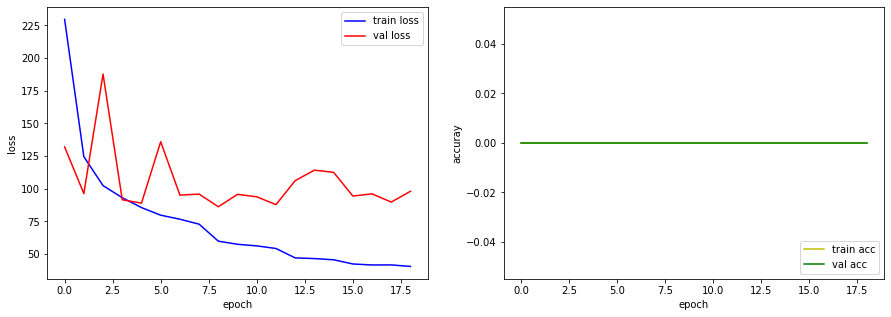

In [ ]:
#학습 과정 표시하기
%matplotlib inline
fig, loss_ax = plt.subplots(1, 2)
fig.set_size_inches((15,5))

loss_ax[0].plot(history.history['loss'], 'b', label='train loss')
loss_ax[0].plot(history.history['val_loss'], 'r', label='val loss')

loss_ax[1].plot(history.history['accuracy'], 'y', label='train acc')
loss_ax[1].plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax[0].set_xlabel('epoch')
loss_ax[0].set_ylabel('loss')
loss_ax[1].set_xlabel('epoch')
loss_ax[1].set_ylabel('accuray')

loss_ax[0].legend(loc='upper right')
loss_ax[1].legend(loc='lower right')

plt.show()

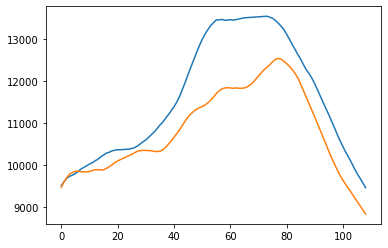

In [ ]:
tl_predict = np.array(yhat).T

#결과 시각화
plt.plot(ytest.reshape(-1))
plt.plot(tl_predict[0])

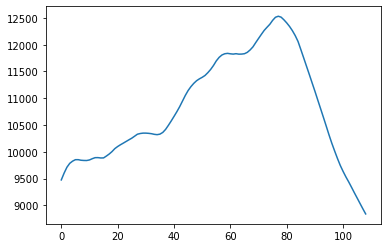

In [ ]:
plt.plot(tl_predict[0])

In [ ]:
tl_predict.shape

(4, 109)

In [ ]:
plt.plot(ydata['청담대교_수위'].iloc[273671:273780])

TypeError: list indices must be integers or slices, not str

In [ ]:
ytest__['청담대교_수위'][273671:273780]

TypeError: list indices must be integers or slices, not str

In [ ]:
ytest_list = sorted(glob("C:/Users/sjkan/Desktop/submission 임시/*.csv"))
ytest__ = []

for i in range(len(ytest_list)):
  tmp = pd.read_csv(ytest_list[i], encoding = 'cp949', usecols=[0])
  ytest__.append(np.array(tmp.iloc[:,1])*100)

IndexError: single positional indexer is out-of-bounds

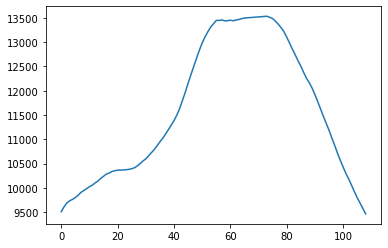

In [ ]:
plt.plot(pd.DataFrame(ytest).loc[:,0])

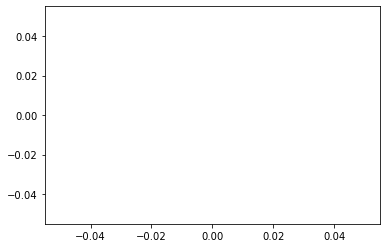

In [ ]:
plt.plot(np.array(ytest__).T[273671:273780])

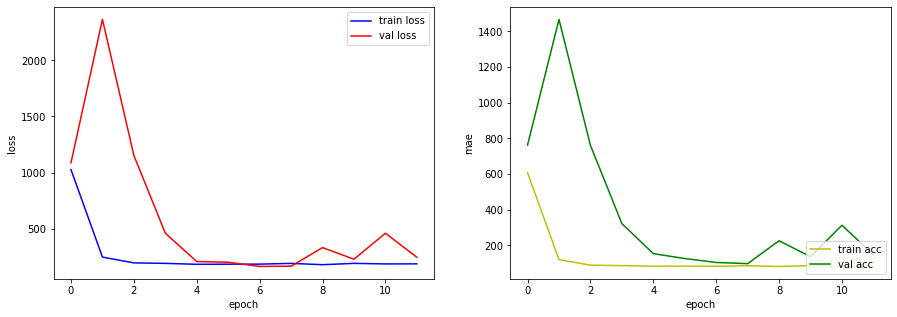

In [ ]:
#점수 채점하기
score = []
for i in range(4):
    print(root_mean_squared_error(ytest_[i], tl_predict[i]))
    score.append(root_mean_squared_error(ytest_[i], tl_predict[i]))
    
print("최종점수: ", np.mean(score))

In [ ]:
#제출 파일 생성

sample_submission = pd.read_csv("C:/Users/sjkan/Desktop/연세/YBIGTA/22 여름방학/신입기수프로젝트/sample_submission.csv")

sample_submission["wl_1018662"] = tl_predict[0]
#sample_submission["wl_1018680"] = tl_predict[1]
#sample_submission["wl_1018683"] = tl_predict[2]
#sample_submission["wl_1019630"] = tl_predict[3]

sample_submission.to_csv("0824 청담대교 유량.csv", index = False)

ValueError: Length of values (109) does not match length of index (6912)

In [ ]:
pd.DataFrame(tl_predict).T.to_csv('0824 청담대교 결측치 cnnlstm.csv', encoding = 'cp949')

In [ ]:
pd.DataFrame(tl_predict).T

,0,1,2,3
0,9475.999023,9459.795898,9472.609375,9449.036133
1,9603.151367,9586.803711,9601.774414,9574.742188
2,9712.863281,9696.363281,9713.487305,9682.821289
3,9785.803711,9769.937500,9788.685547,9755.486328
4,9826.315430,9812.200195,9828.520508,9800.446289
...,...,...,...,...
104,9235.555664,9236.968750,9231.488281,9242.122070
105,9136.816406,9138.067383,9133.453125,9143.390625
106,9036.924805,9038.045898,9034.308594,9043.583984
107,8937.915039,8938.934570,8936.090820,8944.737305
